# Evaluating cloud dilation options for Landsat Fmask <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)



## Getting started

### Load packages
Import Python packages used for the analysis.


In [1]:
import datacube
from datacube.utils.masking import make_mask
from odc.algo import mask_cleanup, erase_bad, enum_to_bool, to_f32
from datacube.utils.geometry import CRS, Geometry, GeoBox

import os
import sys
import fiona
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(1, "../Tools/")
from dea_tools.dask import create_local_dask_cluster

# Launch Dask cluster
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 94,Total memory: 697.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40581,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 94
Started: Just now,Total memory: 697.21 GiB
Comm: tcp://127.0.0.1:46081,Total threads: 94
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/39565/status,Memory: 697.21 GiB
Nanny: tcp://127.0.0.1:37629,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Cloud_dilation-analysis")

### Assumptions

In [3]:
start_buffering = 0
end_buffering = 20
bands = [
    "nbart_blue",
    "nbart_red",
    "nbart_green",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
    "oa_fmask",
]
products = [
    "ga_ls5t_ard_3",
    "ga_ls7e_ard_3",
    "ga_ls8c_ard_3",
    "ga_ls9c_ard_3",
]
maturity = "final"
time_period = None  # ("1990", "1995")   # ('2015-01-01', '2015-05-01')  # # Set to none for entire sensor record, otherwise:  # ('2015-01-01', '2015-05-01')
path_row_list_full = [
    "113082",
    "111077",
    "108083",
    "108079",
    "105069",
    "103073",
    "099079",
    "098077",
    "097081",
    "095082",
    "094085",
    "093086",
    "096072",
    "091090",
    "090086",
    "090084",
    "090085",
    "091079",
    "090084",
    "089084",
    "090079",
    "089079",
]
# smaller path row list for testing purposes
path_row_list = [
    "113082",
    "111077",
]

In [4]:
def landsat_scene_poly(path_row, radius=None):
    """
    Get geometry for a given landsat path row

    Parameters
    ----------
    path_row : string
        Path row to search for
    radius : int, optional
        If provided, the centroid of the path row geom will be buffered
        by `radius` metres to provide a smaller geometry located within
        the path row, reducing memory and processing.

    Returns
    -------
    geometry : geometry
        geopolygon for given path row
    """

    # Path to Landsat file on S3
    landsat_shape = "https://data.dea.ga.gov.au/derivative/ga_ls_path_row_grid.geojson"

    # Select feature
    with fiona.open(landsat_shape) as all_shapes:
        for s in all_shapes:
            # landsat pathrows dont include 0 in front hence convert path-row to int to drop 0
            if s["properties"].get("PR") == int(path_row):
                # Extract geom
                geom = Geometry(s["geometry"], crs=CRS("EPSG:4326"))

                # Buffer centroid by X and return geom
                if radius is not None:
                    geom = geom.to_crs("EPSG:3577").centroid.buffer(radius)

                return geom

### Select spatiotemporal query

In [5]:
# for full path-row geopolygon
def define_query_params(path_row, time_period, maturity, radius=None):
    """
    Create query params for odc load

    Parameters
    ----------
    path_row : string
        Path row to search for
    time_period : list
        Time range
    maturity : string
        The dataset maturity level to include in the analysis
    radius : int, optional
        If provided, the centroid of the path row geom will be buffered
        by `radius` metres to provide a smaller geometry located within
        the path row, reducing memory and processing.

    Returns
    -------
    query_params : dictionary
        qury params to use for odc load
    """
    query_poly = landsat_scene_poly(path_row, radius)
    query_params = {
        "geopolygon": query_poly,
        "time": time_period,
        "region_code": path_row,
        "dataset_maturity": maturity,
    }
    return query_params


# for small scale fast tests
def define_query_params_lat_lon_test(time_period):
    query_params = dict(x=(140, 140.1), y=(-30, -30.1), time=time_period)
    return query_params

## Load data


In [6]:
def load_data(bands, products, query_params):
    """
    Load odc data

    Parameters
    ----------
    bands : string
        measurement bands
    products : string
        odc products
    query_params: dictionary
        odc query parameters

    Returns
    -------
    ds : dataset
        geospatial satellite data dataset
    """

    # Find matching datasets
    dss = dc.find_datasets(product=products, **query_params)

    # Identify native CRS from datasets; fall back on "EPSG:3577"
    # if no data is found to prevent an error
    native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    # Set load params (measurements to load, Dask chunking, resampling etc)
    load_params = dict(
        measurements=bands,
        output_crs=native_crs,  # Native CRS
        resolution=(-30, 30),  # Native resolution
        align=(15, 15),  # Required for native resolution load
        group_by="solar_day",
        dask_chunks={}, 
    )

    # Lazily load data
    ds = dc.load(product=products, **query_params, **load_params)

    return ds

## Fmask cloud and shadow mask
Based on content from: https://docs.dea.ga.gov.au/notebooks/How_to_guides/Masking_data.html

In [7]:
def calc_cloud_shadow_mask(ds):
    """
    Calculate cloud shadow mask

    Parameters
    ----------
    ds : dataset
        data

    Returns
    -------
    cloud_shadow_mask : xr.DataArray
        cloud shadow mask
    nodata_mask: xr.DataArray
        nodata mask
    """
    # Identify pixels that are either "nodata", "cloud" or "cloud_shadow"
    nodata_mask = enum_to_bool(ds.oa_fmask, categories=["nodata"])
    cloud_shadow_mask = enum_to_bool(ds.oa_fmask, categories=["cloud", "shadow"])

    return cloud_shadow_mask, nodata_mask


# Plot
# cloud_shadow_mask.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

### Applying dilation using `mask_cleanup`

In [8]:
def get_std(buffer_size, ds, cloud_shadow_mask, nodata_mask):
    """
    Calculate standard deviation

    Parameters
    ----------
    buffer_size : integer
        pixel buffer size
    ds : dataset
        odc data
    cloud_shadow_mask : xr.DataArray
        cloud shadow mask
    nodata_mask: xr.DataArray
        nodata mask

    Returns
    -------
    std_df : pandas.DataFrame
        A pandas DataFrame containing mean standard deviation for
        each satellite band
    """
    # Dilate all cloud and cloud shadow pixels by n pixels (uses a circular disk)
    cloud_shadow_buffered = mask_cleanup(
        mask=cloud_shadow_mask, mask_filters=[("dilation", buffer_size)]
    )

    # Apply the mask and drop cloud masking band
    combined_mask = cloud_shadow_buffered | nodata_mask
    clear_buffered = erase_bad(ds.drop("oa_fmask"), combined_mask)

    # Convert to float, setting all nodata pixels to `np.nan` (required
    # for the standard deviation calculation)
    clear_buffered = to_f32(clear_buffered)

    # Calculate the mean of standard deviation through time at each pixel.
    # Xarray will apply this to each band in the dataset individually
    std_ds = clear_buffered.std(dim="time").mean().compute()

    # Convert xarray.DataSet to pandas.DataFrame
    std_df = std_ds.drop("spatial_ref").to_array().to_dataframe(name="std")

    return std_df


def std_buffer_comp(start_buffering, end_buffering, ds, cloud_shadow_mask, nodata_mask):
    """
    Calculate buffer comparison standard deviation

    Parameters
    ----------
    start_buffering, end_buffering : integer
        pixel buffer size
    ds : dataset
        odc data
    cloud_shadow_mask : xr.DataArray
        cloud shadow mask
    nodata_mask: xr.DataArray
        nodata mask

    Returns
    -------
    std_buffer_df : pandas.DataFrame
        A pandas DataFrame containing mean standard deviation per buffer
        pixel per band
    """

    output_dict = {}

    # Loop through each buffer radius
    for buffer in range(start_buffering, end_buffering + 1):
        # Calculate mean standard deviation through time for buffer
        std_df = get_std(buffer, ds, cloud_shadow_mask, nodata_mask)

        # Add outputs to dictionary with cloud buffer as key
        output_dict[buffer] = std_df

        # Print results
        print(
            f"Buffer in pixels: {buffer}, {': '.join(std_df.round(1).to_string(index_names=False).split())}"
        )

    # Concatenate outputs into a single dataframe, then unstack to wide 
    # format with each variable as a column
    std_buffer_df = pd.concat(output_dict, names=["pixel_buffer", "variable"])[
        "std"
    ].unstack("variable")

    return std_buffer_df

### Plot standard deviation and gradient vs buffer size in pixels

In [9]:
def plot_std_gradient_buffer(
    std_buffer_df, path_row, product, start_buffering, end_buffering, export_figure=True
):
    # Set up three panel fig
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    plt.subplots_adjust(wspace=0.3)

    # Apply numpy gradient to each column in dataset
    std_gradient_df = std_buffer_df.apply(np.gradient, axis=0)

    # Plot standard deviation
    std_buffer_df.plot(
        ax=axes[0],
        xlabel="Buffer distance",
        ylabel="Standard deviation",
        title=f"Standard devation per buffer pixel",
        legend=False,
    )

    # Plot gradient
    std_gradient_df.plot(
        ax=axes[1],
        xlabel="Buffer distance",
        ylabel="Standard deviation gradient",
        title=f"Standard devation gradient per buffer pixel",
    )

    # Add labels to every second item
    for index in std_gradient_df.index[::2]:
        axes[1].text(
            index,
            std_gradient_df.nbart_blue.loc[index],
            round(std_gradient_df.nbart_blue.loc[index], 2),
            size=8,
        )

    # Plot mean of all gradients
    std_gradient_df_mean = std_gradient_df.mean(axis=1).to_frame("All bands")
    std_gradient_df_mean.plot(
        ax=axes[2],
        xlabel="Buffer distance",
        ylabel="Standard deviation gradient",
        title=f"Standard devation gradient per buffer pixel",
    )

    # Add labels to every second item
    for index in std_gradient_df_mean.index[::2]:
        axes[2].text(
            index,
            std_gradient_df_mean["All bands"].loc[index],
            round(std_gradient_df_mean["All bands"].loc[index], 2),
            size=8,
        )

    # Set grid and x-ticks
    for ax in axes:
        ax.grid(alpha=0.1)
        ax.set_xticks([i for i in range(start_buffering, end_buffering)])

    # Add title above subplots
    fig.suptitle(f"Path/row {path_row}, {product}", fontsize=14)
    plt.show()

    # Optionally export figure
    if export_figure:
        fig.savefig(
            f"output_data/{path_row}_{product}_std_gradient.jpg", bbox_inches="tight"
        )

## Run Cloud Buffering Analysis for all selected validation products and path-rows

Processing path/row 113082, product ga_ls5t_ard_3
Buffer in pixels: 0, std: nbart_blue: 345.200012: nbart_red: 401.000000: nbart_green: 395.100006: nbart_nir: 409.899994: nbart_swir_1: 317.100006: nbart_swir_2: 276.399994
Buffer in pixels: 1, std: nbart_blue: 298.399994: nbart_red: 338.399994: nbart_green: 335.100006: nbart_nir: 343.100006: nbart_swir_1: 257.700012: nbart_swir_2: 224.199997
Buffer in pixels: 2, std: nbart_blue: 258.399994: nbart_red: 283.200012: nbart_green: 282.299988: nbart_nir: 284.200012: nbart_swir_1: 206.800003: nbart_swir_2: 179.800003
Buffer in pixels: 3, std: nbart_blue: 221.800003: nbart_red: 233.000000: nbart_green: 234.399994: nbart_nir: 231.199997: nbart_swir_1: 163.399994: nbart_swir_2: 142.500000
Buffer in pixels: 4, std: nbart_blue: 199.199997: nbart_red: 203.300003: nbart_green: 205.899994: nbart_nir: 200.399994: nbart_swir_1: 140.300003: nbart_swir_2: 123.199997
Buffer in pixels: 5, std: nbart_blue: 178.000000: nbart_red: 177.000000: nbart_green: 180.

2023-07-06 07:31:55,182 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-07-06 07:32:03,014 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 10, std: nbart_blue: 135.500000: nbart_red: 126.500000: nbart_green: 131.800003: nbart_nir: 122.599998: nbart_swir_1: 92.599998: nbart_swir_2: 85.000000


2023-07-06 07:32:11,788 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:32:17,817 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:32:25,457 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 11, std: nbart_blue: 131.500000: nbart_red: 122.099998: nbart_green: 127.500000: nbart_nir: 118.300003: nbart_swir_1: 90.400002: nbart_swir_2: 83.199997


2023-07-06 07:32:33,529 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:32:40,914 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:32:48,003 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 12, std: nbart_blue: 128.000000: nbart_red: 118.300003: nbart_green: 123.800003: nbart_nir: 114.500000: nbart_swir_1: 88.599998: nbart_swir_2: 81.699997


2023-07-06 07:32:56,094 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:33:03,852 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:33:12,203 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 13, std: nbart_blue: 124.300003: nbart_red: 114.300003: nbart_green: 119.800003: nbart_nir: 110.599998: nbart_swir_1: 86.699997: nbart_swir_2: 80.199997


2023-07-06 07:33:19,608 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:33:28,152 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 14, std: nbart_blue: 121.500000: nbart_red: 111.300003: nbart_green: 116.900002: nbart_nir: 107.699997: nbart_swir_1: 85.300003: nbart_swir_2: 79.000000


2023-07-06 07:33:38,810 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:33:45,294 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:33:53,590 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Buffer in pixels: 15, std: nbart_blue: 119.000000: nbart_red: 108.699997: nbart_green: 114.300003: nbart_nir: 105.199997: nbart_swir_1: 83.900002: nbart_swir_2: 77.900002


2023-07-06 07:34:03,408 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:34:11,454 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-06 07:34:21,411 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Buffer in pixels: 16, std: nbart_blue: 117.099998: nbart_red: 106.599998: nbart_green: 112.400002: nbart_nir: 103.199997: nbart_swir_1: 82.900002: nbart_swir_2: 77.000000


2023-07-06 07:34:31,338 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:34:40,745 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:34:50,530 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Buffer in pixels: 17, std: nbart_blue: 115.099998: nbart_red: 104.699997: nbart_green: 110.400002: nbart_nir: 101.300003: nbart_swir_1: 81.900002: nbart_swir_2: 76.099998


2023-07-06 07:35:00,696 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:35:12,348 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:35:21,921 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Buffer in pixels: 18, std: nbart_blue: 113.500000: nbart_red: 103.000000: nbart_green: 108.699997: nbart_nir: 99.699997: nbart_swir_1: 81.000000: nbart_swir_2: 75.400002


2023-07-06 07:35:34,850 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:35:47,129 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Buffer in pixels: 19, std: nbart_blue: 111.900002: nbart_red: 101.400002: nbart_green: 107.199997: nbart_nir: 98.099998: nbart_swir_1: 80.199997: nbart_swir_2: 74.599998


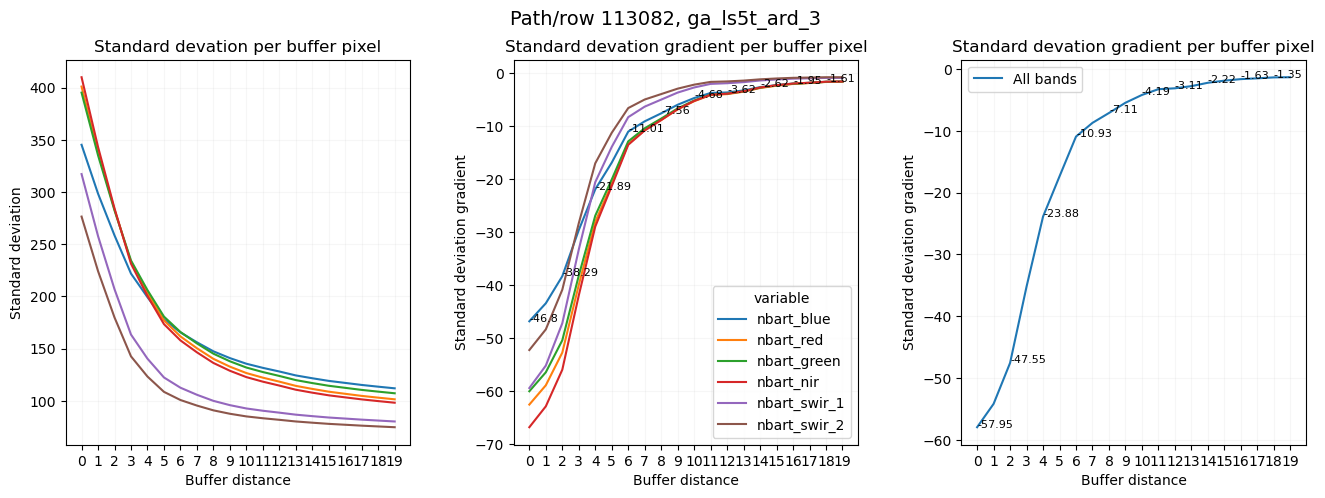

Processing path/row 113082, product ga_ls7e_ard_3


2023-07-06 07:36:01,240 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:36:05,931 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:36:09,653 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:36:12,686 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-07-06 07:36:16,117 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-07-06 07:36:20,545 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-07-06 07:36:24,470 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-07-06 07:36:30,156 - distributed.utils_perf - WARNING - full garbage collections took

Buffer in pixels: 0, std: nbart_blue: 343.799988: nbart_red: 345.200012: nbart_green: 340.200012: nbart_nir: 339.299988: nbart_swir_1: 223.399994: nbart_swir_2: 194.600006


2023-07-06 07:36:51,431 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-07-06 07:36:59,882 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-07-06 07:37:08,501 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 1, std: nbart_blue: 315.200012: nbart_red: 315.200012: nbart_green: 311.100006: nbart_nir: 309.299988: nbart_swir_1: 196.699997: nbart_swir_2: 166.899994


2023-07-06 07:37:17,299 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:37:26,062 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:37:35,289 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 2, std: nbart_blue: 293.200012: nbart_red: 292.000000: nbart_green: 288.500000: nbart_nir: 286.399994: nbart_swir_1: 178.699997: nbart_swir_2: 148.899994


2023-07-06 07:37:44,121 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:37:52,917 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:38:02,223 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 3, std: nbart_blue: 271.000000: nbart_red: 268.200012: nbart_green: 265.600006: nbart_nir: 263.200012: nbart_swir_1: 162.100006: nbart_swir_2: 133.300003


2023-07-06 07:38:11,247 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:38:19,588 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 4, std: nbart_blue: 254.399994: nbart_red: 250.399994: nbart_green: 248.300003: nbart_nir: 245.899994: nbart_swir_1: 150.600006: nbart_swir_2: 123.000000


2023-07-06 07:38:30,583 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:38:37,208 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:38:45,893 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 5, std: nbart_blue: 235.600006: nbart_red: 230.000000: nbart_green: 228.600006: nbart_nir: 226.199997: nbart_swir_1: 138.600006: nbart_swir_2: 112.800003


2023-07-06 07:38:57,023 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:39:04,129 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:39:13,090 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Buffer in pixels: 6, std: nbart_blue: 221.899994: nbart_red: 215.100006: nbart_green: 214.199997: nbart_nir: 211.800003: nbart_swir_1: 130.399994: nbart_swir_2: 106.199997


2023-07-06 07:39:23,271 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:39:30,734 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-07-06 07:39:40,002 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


Buffer in pixels: 7, std: nbart_blue: 209.800003: nbart_red: 201.899994: nbart_green: 201.399994: nbart_nir: 199.100006: nbart_swir_1: 123.599998: nbart_swir_2: 100.800003


2023-07-06 07:39:49,668 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:39:57,903 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:40:06,582 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 8, std: nbart_blue: 197.000000: nbart_red: 188.000000: nbart_green: 187.899994: nbart_nir: 185.800003: nbart_swir_1: 117.000000: nbart_swir_2: 95.800003


2023-07-06 07:40:16,944 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:40:25,485 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:40:34,858 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 9, std: nbart_blue: 185.500000: nbart_red: 175.500000: nbart_green: 175.699997: nbart_nir: 173.800003: nbart_swir_1: 111.400002: nbart_swir_2: 91.800003


2023-07-06 07:40:44,380 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-07-06 07:40:53,715 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-07-06 07:41:03,242 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


Buffer in pixels: 10, std: nbart_blue: 174.699997: nbart_red: 163.899994: nbart_green: 164.399994: nbart_nir: 162.699997: nbart_swir_1: 106.699997: nbart_swir_2: 88.500000


2023-07-06 07:41:12,596 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:41:22,282 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:41:32,264 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 11, std: nbart_blue: 166.800003: nbart_red: 155.300003: nbart_green: 156.000000: nbart_nir: 154.500000: nbart_swir_1: 103.400002: nbart_swir_2: 86.199997


2023-07-06 07:41:42,312 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:41:53,019 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 12, std: nbart_blue: 159.800003: nbart_red: 147.800003: nbart_green: 148.600006: nbart_nir: 147.399994: nbart_swir_1: 100.599998: nbart_swir_2: 84.400002


2023-07-06 07:42:05,077 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:42:13,021 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:42:23,439 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 13, std: nbart_blue: 152.000000: nbart_red: 139.399994: nbart_green: 140.399994: nbart_nir: 139.399994: nbart_swir_1: 97.599998: nbart_swir_2: 82.500000


2023-07-06 07:42:36,158 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:42:45,963 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:42:56,932 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 14, std: nbart_blue: 146.100006: nbart_red: 133.100006: nbart_green: 134.300003: nbart_nir: 133.500000: nbart_swir_1: 95.400002: nbart_swir_2: 81.199997


2023-07-06 07:43:04,312 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:43:08,305 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-07-06 07:43:19,801 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:43:31,493 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 15, std: nbart_blue: 140.600006: nbart_red: 127.300003: nbart_green: 128.500000: nbart_nir: 128.000000: nbart_swir_1: 93.500000: nbart_swir_2: 80.099998


2023-07-06 07:43:43,327 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:43:56,486 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 16, std: nbart_blue: 136.500000: nbart_red: 123.000000: nbart_green: 124.199997: nbart_nir: 123.900002: nbart_swir_1: 92.000000: nbart_swir_2: 79.199997


2023-07-06 07:44:11,381 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:44:21,828 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:44:35,239 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 17, std: nbart_blue: 132.300003: nbart_red: 118.500000: nbart_green: 119.800003: nbart_nir: 119.699997: nbart_swir_1: 90.599998: nbart_swir_2: 78.400002


2023-07-06 07:44:50,260 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:45:03,343 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:45:18,189 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 18, std: nbart_blue: 128.800003: nbart_red: 114.900002: nbart_green: 116.199997: nbart_nir: 116.300003: nbart_swir_1: 89.300003: nbart_swir_2: 77.599998


2023-07-06 07:45:32,337 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:45:48,582 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:46:04,373 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 19, std: nbart_blue: 125.699997: nbart_red: 111.699997: nbart_green: 113.000000: nbart_nir: 113.300003: nbart_swir_1: 88.199997: nbart_swir_2: 77.000000


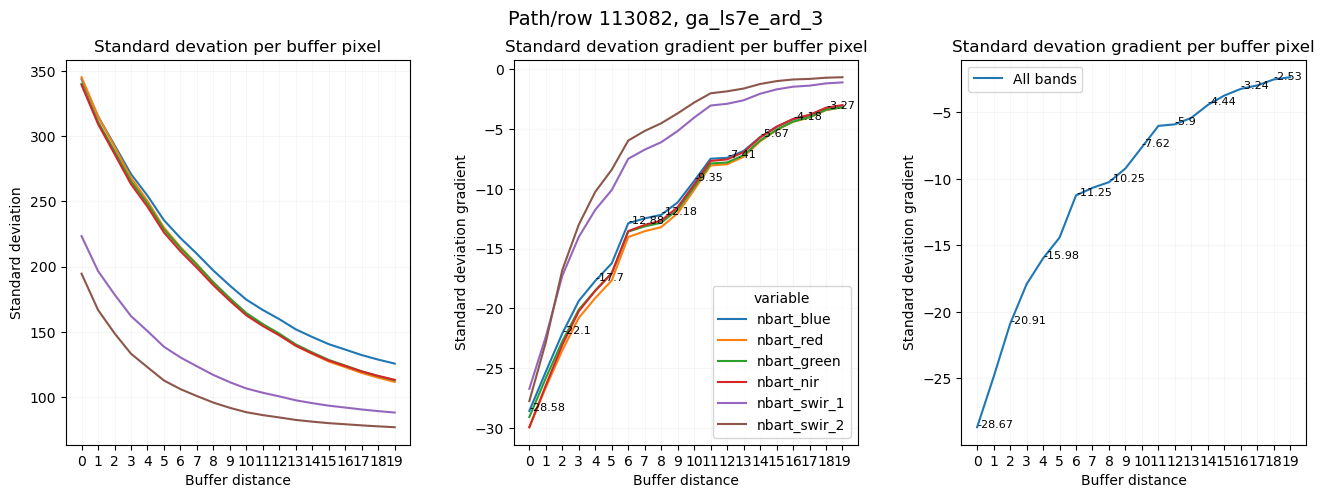

Processing path/row 113082, product ga_ls8c_ard_3


2023-07-06 07:46:16,325 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:46:21,272 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:46:25,597 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:46:31,351 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 0, std: nbart_blue: 487.000000: nbart_red: 492.299988: nbart_green: 489.000000: nbart_nir: 492.200012: nbart_swir_1: 345.399994: nbart_swir_2: 276.399994


2023-07-06 07:46:38,801 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:46:46,662 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 1, std: nbart_blue: 464.299988: nbart_red: 469.299988: nbart_green: 466.600006: nbart_nir: 469.899994: nbart_swir_1: 322.000000: nbart_swir_2: 249.000000


2023-07-06 07:46:55,133 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 2, std: nbart_blue: 451.299988: nbart_red: 456.100006: nbart_green: 453.799988: nbart_nir: 457.399994: nbart_swir_1: 307.399994: nbart_swir_2: 231.000000


2023-07-06 07:47:04,862 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:47:11,673 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 3, std: nbart_blue: 441.100006: nbart_red: 445.600006: nbart_green: 443.500000: nbart_nir: 447.600006: nbart_swir_1: 295.799988: nbart_swir_2: 216.600006


2023-07-06 07:47:20,384 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:47:27,842 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 4, std: nbart_blue: 434.700012: nbart_red: 439.200012: nbart_green: 437.100006: nbart_nir: 441.500000: nbart_swir_1: 289.200012: nbart_swir_2: 208.899994


2023-07-06 07:47:36,796 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:47:44,557 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 5, std: nbart_blue: 428.399994: nbart_red: 432.799988: nbart_green: 430.799988: nbart_nir: 435.600006: nbart_swir_1: 283.500000: nbart_swir_2: 202.500000


2023-07-06 07:47:53,193 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 6, std: nbart_blue: 424.000000: nbart_red: 428.399994: nbart_green: 426.299988: nbart_nir: 431.399994: nbart_swir_1: 279.899994: nbart_swir_2: 198.800003


2023-07-06 07:48:02,385 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:48:09,764 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 7, std: nbart_blue: 419.799988: nbart_red: 424.399994: nbart_green: 422.200012: nbart_nir: 427.500000: nbart_swir_1: 276.799988: nbart_swir_2: 195.800003


2023-07-06 07:48:18,341 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:48:26,514 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 8, std: nbart_blue: 415.200012: nbart_red: 419.799988: nbart_green: 417.600006: nbart_nir: 423.100006: nbart_swir_1: 273.700012: nbart_swir_2: 192.899994


2023-07-06 07:48:35,659 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 9, std: nbart_blue: 410.899994: nbart_red: 415.600006: nbart_green: 413.299988: nbart_nir: 419.100006: nbart_swir_1: 270.899994: nbart_swir_2: 190.500000


2023-07-06 07:48:45,525 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:48:53,386 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 10, std: nbart_blue: 406.700012: nbart_red: 411.500000: nbart_green: 409.100006: nbart_nir: 415.100006: nbart_swir_1: 268.299988: nbart_swir_2: 188.399994


2023-07-06 07:49:02,523 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:49:11,431 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 11, std: nbart_blue: 403.299988: nbart_red: 408.200012: nbart_green: 405.799988: nbart_nir: 411.899994: nbart_swir_1: 266.299988: nbart_swir_2: 186.699997


2023-07-06 07:49:21,598 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 12, std: nbart_blue: 400.100006: nbart_red: 405.000000: nbart_green: 402.600006: nbart_nir: 408.799988: nbart_swir_1: 264.399994: nbart_swir_2: 185.199997


2023-07-06 07:49:32,103 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 07:49:40,100 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Buffer in pixels: 13, std: nbart_blue: 396.100006: nbart_red: 401.000000: nbart_green: 398.500000: nbart_nir: 404.899994: nbart_swir_1: 261.899994: nbart_swir_2: 183.399994


2023-07-06 07:49:49,941 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:49:59,720 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 14, std: nbart_blue: 392.600006: nbart_red: 397.500000: nbart_green: 395.000000: nbart_nir: 401.500000: nbart_swir_1: 259.799988: nbart_swir_2: 181.800003


2023-07-06 07:50:10,460 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:50:21,022 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 15, std: nbart_blue: 388.799988: nbart_red: 393.700012: nbart_green: 391.200012: nbart_nir: 397.700012: nbart_swir_1: 257.500000: nbart_swir_2: 180.199997


2023-07-06 07:50:31,842 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 16, std: nbart_blue: 385.500000: nbart_red: 390.399994: nbart_green: 387.899994: nbart_nir: 394.399994: nbart_swir_1: 255.600006: nbart_swir_2: 178.800003


2023-07-06 07:50:44,201 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:50:56,100 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 17, std: nbart_blue: 381.700012: nbart_red: 386.600006: nbart_green: 384.100006: nbart_nir: 390.600006: nbart_swir_1: 253.300003: nbart_swir_2: 177.300003


2023-07-06 07:51:08,947 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 18, std: nbart_blue: 378.100006: nbart_red: 382.899994: nbart_green: 380.399994: nbart_nir: 387.000000: nbart_swir_1: 251.199997: nbart_swir_2: 175.800003


2023-07-06 07:51:22,530 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:51:33,737 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 19, std: nbart_blue: 374.200012: nbart_red: 379.000000: nbart_green: 376.500000: nbart_nir: 383.100006: nbart_swir_1: 248.899994: nbart_swir_2: 174.300003


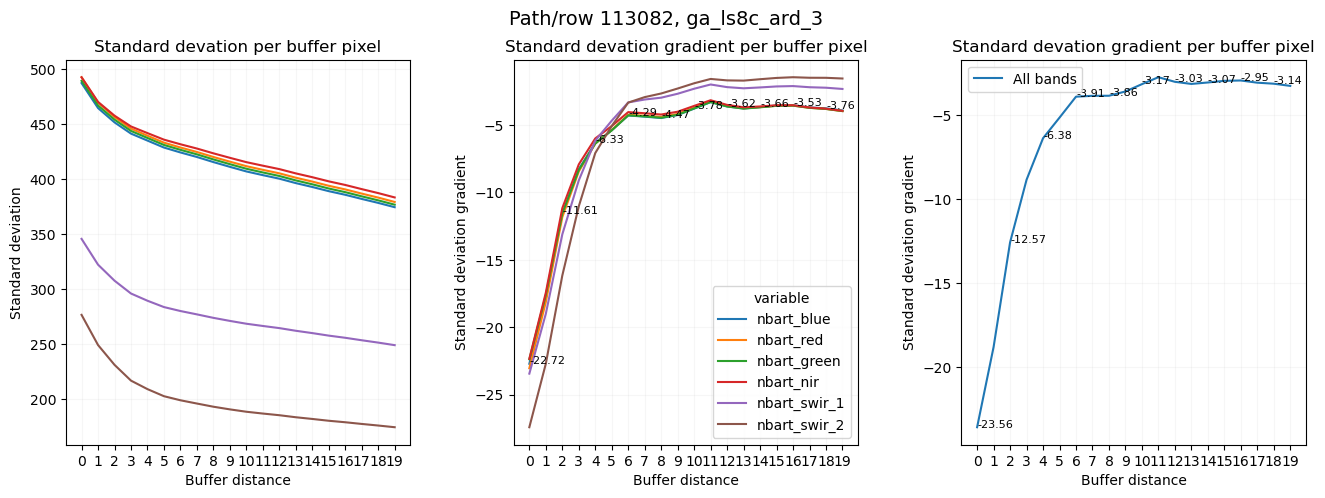

Processing path/row 113082, product ga_ls9c_ard_3
Error - possibly no data for ga_ls9c_ard_3. 'Dataset' object has no attribute 'oa_fmask'
Processing path/row 111077, product ga_ls5t_ard_3


2023-07-06 07:51:50,898 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:51:57,126 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 07:52:01,864 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 07:52:07,457 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 07:52:13,063 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 07:52:19,990 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 0, std: nbart_blue: 157.699997: nbart_red: 207.500000: nbart_green: 163.100006: nbart_nir: 248.500000: nbart_swir_1: 354.799988: nbart_swir_2: 341.799988


2023-07-06 07:52:30,713 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 07:52:38,311 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 07:52:47,833 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 1, std: nbart_blue: 141.100006: nbart_red: 195.100006: nbart_green: 146.500000: nbart_nir: 234.399994: nbart_swir_1: 337.700012: nbart_swir_2: 327.200012


2023-07-06 07:52:57,670 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-06 07:53:07,409 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


Buffer in pixels: 2, std: nbart_blue: 131.100006: nbart_red: 188.600006: nbart_green: 137.199997: nbart_nir: 227.000000: nbart_swir_1: 328.899994: nbart_swir_2: 319.799988


2023-07-06 07:53:17,302 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-06 07:53:27,196 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


Buffer in pixels: 3, std: nbart_blue: 122.800003: nbart_red: 183.600006: nbart_green: 129.899994: nbart_nir: 221.100006: nbart_swir_1: 322.000000: nbart_swir_2: 314.000000


2023-07-06 07:53:38,430 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-06 07:53:47,510 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


Buffer in pixels: 4, std: nbart_blue: 117.500000: nbart_red: 180.300003: nbart_green: 125.199997: nbart_nir: 217.000000: nbart_swir_1: 317.000000: nbart_swir_2: 309.899994


2023-07-06 07:53:59,720 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-06 07:54:08,026 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-06 07:54:17,699 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


Buffer in pixels: 5, std: nbart_blue: 112.000000: nbart_red: 176.800003: nbart_green: 120.199997: nbart_nir: 212.500000: nbart_swir_1: 311.399994: nbart_swir_2: 305.200012


2023-07-06 07:54:28,255 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-06 07:54:38,312 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Buffer in pixels: 6, std: nbart_blue: 108.400002: nbart_red: 174.399994: nbart_green: 117.000000: nbart_nir: 209.399994: nbart_swir_1: 307.399994: nbart_swir_2: 301.899994


2023-07-06 07:54:48,863 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-06 07:54:58,691 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Buffer in pixels: 7, std: nbart_blue: 105.300003: nbart_red: 172.399994: nbart_green: 114.199997: nbart_nir: 206.699997: nbart_swir_1: 303.700012: nbart_swir_2: 298.899994


2023-07-06 07:55:09,910 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-06 07:55:19,949 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


Buffer in pixels: 8, std: nbart_blue: 102.199997: nbart_red: 170.199997: nbart_green: 111.300003: nbart_nir: 203.699997: nbart_swir_1: 299.799988: nbart_swir_2: 295.700012


2023-07-06 07:55:31,264 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-06 07:55:40,870 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Buffer in pixels: 9, std: nbart_blue: 99.500000: nbart_red: 168.399994: nbart_green: 109.000000: nbart_nir: 201.199997: nbart_swir_1: 296.299988: nbart_swir_2: 292.799988


2023-07-06 07:55:53,331 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-06 07:56:01,782 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-06 07:56:12,450 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Buffer in pixels: 10, std: nbart_blue: 97.000000: nbart_red: 166.800003: nbart_green: 106.800003: nbart_nir: 198.899994: nbart_swir_1: 292.899994: nbart_swir_2: 290.100006


2023-07-06 07:56:23,995 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-06 07:56:35,080 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Buffer in pixels: 11, std: nbart_blue: 95.199997: nbart_red: 165.600006: nbart_green: 105.300003: nbart_nir: 197.100006: nbart_swir_1: 290.299988: nbart_swir_2: 287.899994


2023-07-06 07:56:47,194 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-06 07:56:58,980 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


Buffer in pixels: 12, std: nbart_blue: 93.599998: nbart_red: 164.500000: nbart_green: 103.900002: nbart_nir: 195.500000: nbart_swir_1: 287.899994: nbart_swir_2: 286.000000


2023-07-06 07:57:10,473 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-06 07:57:22,207 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 13, std: nbart_blue: 91.699997: nbart_red: 163.199997: nbart_green: 102.199997: nbart_nir: 193.600006: nbart_swir_1: 285.000000: nbart_swir_2: 283.600006


2023-07-06 07:57:28,022 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:57:34,971 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 07:57:47,391 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 14, std: nbart_blue: 90.199997: nbart_red: 162.199997: nbart_green: 101.000000: nbart_nir: 192.100006: nbart_swir_1: 282.700012: nbart_swir_2: 281.799988


2023-07-06 07:57:54,223 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:57:55,700 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:58:00,568 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 07:58:14,189 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 15, std: nbart_blue: 88.699997: nbart_red: 161.199997: nbart_green: 99.699997: nbart_nir: 190.600006: nbart_swir_1: 280.399994: nbart_swir_2: 279.899994


2023-07-06 07:58:22,751 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:58:27,104 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 07:58:40,298 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 16, std: nbart_blue: 87.599998: nbart_red: 160.399994: nbart_green: 98.800003: nbart_nir: 189.399994: nbart_swir_1: 278.500000: nbart_swir_2: 278.399994


2023-07-06 07:58:51,002 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:58:55,209 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 07:59:09,449 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 17, std: nbart_blue: 86.300003: nbart_red: 159.600006: nbart_green: 97.699997: nbart_nir: 188.199997: nbart_swir_1: 276.500000: nbart_swir_2: 276.799988


2023-07-06 07:59:21,050 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:59:25,499 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 07:59:40,033 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 18, std: nbart_blue: 85.199997: nbart_red: 158.899994: nbart_green: 96.800003: nbart_nir: 187.100006: nbart_swir_1: 274.799988: nbart_swir_2: 275.399994


2023-07-06 07:59:53,637 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:59:55,008 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 07:59:57,850 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:00:14,023 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 19, std: nbart_blue: 84.199997: nbart_red: 158.100006: nbart_green: 95.900002: nbart_nir: 186.000000: nbart_swir_1: 273.000000: nbart_swir_2: 274.000000


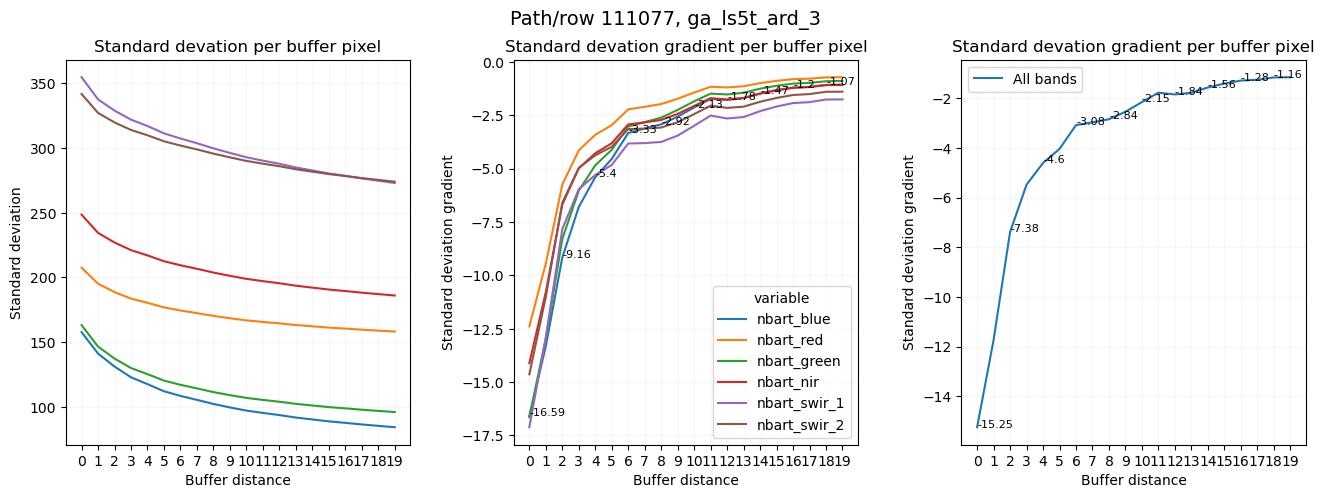

Processing path/row 111077, product ga_ls7e_ard_3


2023-07-06 08:00:34,229 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:00:36,128 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:00:36,538 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-07-06 08:00:43,091 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:00:48,950 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:00:54,833 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:01:00,037 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:01:07,174 - distributed.utils_perf - WARNING - full garbage collections took

Buffer in pixels: 0, std: nbart_blue: 149.300003: nbart_red: 207.100006: nbart_green: 144.300003: nbart_nir: 247.199997: nbart_swir_1: 336.899994: nbart_swir_2: 355.600006


2023-07-06 08:01:27,279 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:01:37,637 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:01:49,207 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 1, std: nbart_blue: 136.899994: nbart_red: 197.399994: nbart_green: 132.800003: nbart_nir: 234.100006: nbart_swir_1: 317.899994: nbart_swir_2: 341.600006


2023-07-06 08:01:57,625 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:02:01,967 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:02:13,564 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 2, std: nbart_blue: 129.199997: nbart_red: 192.199997: nbart_green: 125.800003: nbart_nir: 227.399994: nbart_swir_1: 309.000000: nbart_swir_2: 335.100006


2023-07-06 08:02:24,452 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:02:26,735 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:02:36,833 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:02:48,364 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 3, std: nbart_blue: 122.599998: nbart_red: 188.100006: nbart_green: 119.900002: nbart_nir: 222.199997: nbart_swir_1: 302.200012: nbart_swir_2: 330.299988


2023-07-06 08:02:52,671 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:02:54,121 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:03:01,480 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:03:13,250 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 4, std: nbart_blue: 118.400002: nbart_red: 185.500000: nbart_green: 116.099998: nbart_nir: 218.800003: nbart_swir_1: 297.700012: nbart_swir_2: 327.100006


2023-07-06 08:03:21,901 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:03:26,050 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:03:37,836 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 5, std: nbart_blue: 114.099998: nbart_red: 182.800003: nbart_green: 112.199997: nbart_nir: 215.100006: nbart_swir_1: 292.700012: nbart_swir_2: 323.700012


2023-07-06 08:03:49,526 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:03:50,822 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:03:52,711 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:04:02,815 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:04:15,680 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 6, std: nbart_blue: 111.199997: nbart_red: 181.000000: nbart_green: 109.599998: nbart_nir: 212.500000: nbart_swir_1: 289.299988: nbart_swir_2: 321.399994


2023-07-06 08:04:20,896 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:04:28,222 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:04:40,815 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 7, std: nbart_blue: 108.699997: nbart_red: 179.399994: nbart_green: 107.400002: nbart_nir: 210.300003: nbart_swir_1: 286.200012: nbart_swir_2: 319.299988


2023-07-06 08:04:48,853 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:04:50,264 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:04:54,463 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:05:06,336 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 8, std: nbart_blue: 106.099998: nbart_red: 177.699997: nbart_green: 105.000000: nbart_nir: 208.000000: nbart_swir_1: 283.000000: nbart_swir_2: 317.100006


2023-07-06 08:05:18,246 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:05:20,874 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:05:31,723 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:05:44,425 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:05:45,411 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Buffer in pixels: 9, std: nbart_blue: 103.800003: nbart_red: 176.300003: nbart_green: 103.000000: nbart_nir: 205.899994: nbart_swir_1: 280.100006: nbart_swir_2: 315.200012


2023-07-06 08:05:49,107 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:05:57,848 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:06:10,847 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 10, std: nbart_blue: 101.699997: nbart_red: 174.899994: nbart_green: 101.099998: nbart_nir: 203.899994: nbart_swir_1: 277.299988: nbart_swir_2: 313.399994


2023-07-06 08:06:18,415 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:06:19,772 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-06 08:06:24,767 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:06:38,321 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 11, std: nbart_blue: 100.099998: nbart_red: 173.899994: nbart_green: 99.699997: nbart_nir: 202.500000: nbart_swir_1: 275.200012: nbart_swir_2: 312.000000


2023-07-06 08:06:49,493 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-07-06 08:06:53,030 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:07:05,408 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:07:19,206 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 12, std: nbart_blue: 98.599998: nbart_red: 173.000000: nbart_green: 98.400002: nbart_nir: 201.100006: nbart_swir_1: 273.399994: nbart_swir_2: 310.799988


2023-07-06 08:07:21,508 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:07:22,755 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:07:34,454 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:07:49,097 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 13, std: nbart_blue: 97.000000: nbart_red: 172.000000: nbart_green: 96.900002: nbart_nir: 199.600006: nbart_swir_1: 271.200012: nbart_swir_2: 309.399994


2023-07-06 08:07:54,400 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:08:03,823 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:08:19,014 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 14, std: nbart_blue: 95.599998: nbart_red: 171.199997: nbart_green: 95.699997: nbart_nir: 198.500000: nbart_swir_1: 269.600006: nbart_swir_2: 308.299988


2023-07-06 08:08:27,425 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:08:28,747 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:08:34,771 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:08:51,210 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 15, std: nbart_blue: 94.300003: nbart_red: 170.500000: nbart_green: 94.599998: nbart_nir: 197.399994: nbart_swir_1: 268.000000: nbart_swir_2: 307.299988


2023-07-06 08:09:03,327 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:09:07,956 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 08:09:23,161 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 16, std: nbart_blue: 93.300003: nbart_red: 169.899994: nbart_green: 93.699997: nbart_nir: 196.500000: nbart_swir_1: 266.799988: nbart_swir_2: 306.500000


2023-07-06 08:09:40,411 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:09:41,751 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:09:43,521 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:09:58,096 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:10:16,923 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 17, std: nbart_blue: 92.199997: nbart_red: 169.300003: nbart_green: 92.800003: nbart_nir: 195.600006: nbart_swir_1: 265.600006: nbart_swir_2: 305.799988


2023-07-06 08:10:22,065 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:10:34,979 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:10:43,473 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:10:54,909 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 18, std: nbart_blue: 91.199997: nbart_red: 168.800003: nbart_green: 91.900002: nbart_nir: 194.899994: nbart_swir_1: 264.500000: nbart_swir_2: 305.100006


2023-07-06 08:11:04,760 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:11:11,914 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-07-06 08:11:34,598 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 19, std: nbart_blue: 90.199997: nbart_red: 168.199997: nbart_green: 91.099998: nbart_nir: 194.100006: nbart_swir_1: 263.500000: nbart_swir_2: 304.399994


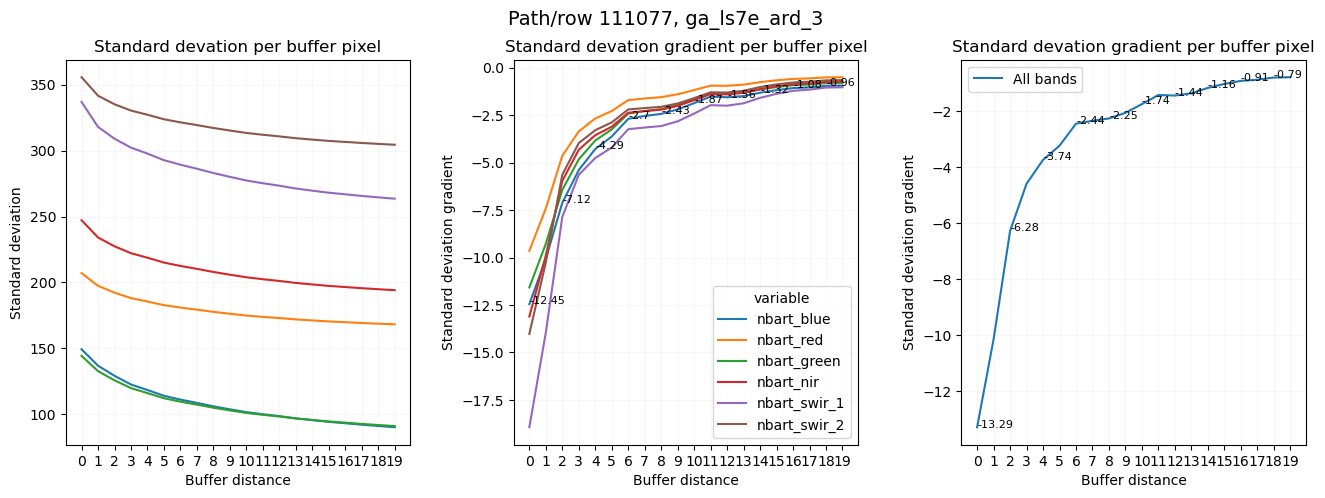

Processing path/row 111077, product ga_ls8c_ard_3


2023-07-06 08:11:52,109 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:11:54,826 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:12:07,055 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:12:09,167 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:12:18,218 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 0, std: nbart_blue: 537.000000: nbart_red: 504.700012: nbart_green: 515.799988: nbart_nir: 484.200012: nbart_swir_1: 385.899994: nbart_swir_2: 370.399994


2023-07-06 08:12:28,250 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 1, std: nbart_blue: 536.000000: nbart_red: 502.299988: nbart_green: 514.700012: nbart_nir: 478.799988: nbart_swir_1: 369.299988: nbart_swir_2: 357.299988


2023-07-06 08:12:37,584 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:12:40,038 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:12:50,651 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 2, std: nbart_blue: 535.700012: nbart_red: 501.299988: nbart_green: 514.400024: nbart_nir: 476.399994: nbart_swir_1: 361.000000: nbart_swir_2: 350.799988


2023-07-06 08:12:53,374 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:13:02,336 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 3, std: nbart_blue: 535.900024: nbart_red: 501.000000: nbart_green: 514.700012: nbart_nir: 475.000000: nbart_swir_1: 355.000000: nbart_swir_2: 346.000000


2023-07-06 08:13:08,075 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:13:13,395 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 4, std: nbart_blue: 536.400024: nbart_red: 501.000000: nbart_green: 515.099976: nbart_nir: 474.200012: nbart_swir_1: 351.000000: nbart_swir_2: 342.799988


2023-07-06 08:13:22,655 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:13:25,597 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 5, std: nbart_blue: 537.299988: nbart_red: 501.200012: nbart_green: 515.900024: nbart_nir: 473.500000: nbart_swir_1: 346.500000: nbart_swir_2: 339.000000


2023-07-06 08:13:37,253 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:13:38,665 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-07-06 08:13:47,903 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 6, std: nbart_blue: 538.099976: nbart_red: 501.500000: nbart_green: 516.599976: nbart_nir: 473.100006: nbart_swir_1: 343.299988: nbart_swir_2: 336.399994


2023-07-06 08:13:59,086 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Buffer in pixels: 7, std: nbart_blue: 538.900024: nbart_red: 501.899994: nbart_green: 517.299988: nbart_nir: 472.799988: nbart_swir_1: 340.399994: nbart_swir_2: 334.100006


2023-07-06 08:14:06,709 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:14:11,123 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 8, std: nbart_blue: 539.900024: nbart_red: 502.299988: nbart_green: 518.200012: nbart_nir: 472.500000: nbart_swir_1: 337.299988: nbart_swir_2: 331.600006


2023-07-06 08:14:21,318 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:14:23,781 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:14:34,798 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 9, std: nbart_blue: 540.799988: nbart_red: 502.700012: nbart_green: 519.000000: nbart_nir: 472.299988: nbart_swir_1: 334.600006: nbart_swir_2: 329.399994


2023-07-06 08:14:38,115 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:14:47,409 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 10, std: nbart_blue: 541.700012: nbart_red: 503.200012: nbart_green: 519.799988: nbart_nir: 472.200012: nbart_swir_1: 332.100006: nbart_swir_2: 327.299988


2023-07-06 08:14:53,670 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:14:59,628 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 11, std: nbart_blue: 542.400024: nbart_red: 503.600006: nbart_green: 520.400024: nbart_nir: 472.100006: nbart_swir_1: 330.100006: nbart_swir_2: 325.799988


2023-07-06 08:15:12,131 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 12, std: nbart_blue: 543.099976: nbart_red: 503.899994: nbart_green: 521.099976: nbart_nir: 472.100006: nbart_swir_1: 328.399994: nbart_swir_2: 324.299988


2023-07-06 08:15:24,578 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:15:26,441 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:15:37,967 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 13, std: nbart_blue: 543.900024: nbart_red: 504.399994: nbart_green: 521.799988: nbart_nir: 472.100006: nbart_swir_1: 326.299988: nbart_swir_2: 322.600006


2023-07-06 08:15:42,352 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:15:51,780 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Buffer in pixels: 14, std: nbart_blue: 544.599976: nbart_red: 504.799988: nbart_green: 522.500000: nbart_nir: 472.100006: nbart_swir_1: 324.700012: nbart_swir_2: 321.299988


2023-07-06 08:15:59,477 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2023-07-06 08:16:06,062 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 15, std: nbart_blue: 545.400024: nbart_red: 505.200012: nbart_green: 523.099976: nbart_nir: 472.200012: nbart_swir_1: 323.100006: nbart_swir_2: 320.000000


2023-07-06 08:16:20,887 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 16, std: nbart_blue: 545.900024: nbart_red: 505.500000: nbart_green: 523.700012: nbart_nir: 472.200012: nbart_swir_1: 321.899994: nbart_swir_2: 319.000000


2023-07-06 08:16:36,824 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-07-06 08:16:51,210 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 17, std: nbart_blue: 546.599976: nbart_red: 505.899994: nbart_green: 524.299988: nbart_nir: 472.299988: nbart_swir_1: 320.600006: nbart_swir_2: 318.000000


2023-07-06 08:17:07,786 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 18, std: nbart_blue: 547.200012: nbart_red: 506.299988: nbart_green: 524.799988: nbart_nir: 472.399994: nbart_swir_1: 319.600006: nbart_swir_2: 317.100006


2023-07-06 08:17:26,876 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Buffer in pixels: 19, std: nbart_blue: 547.799988: nbart_red: 506.700012: nbart_green: 525.299988: nbart_nir: 472.500000: nbart_swir_1: 318.500000: nbart_swir_2: 316.200012


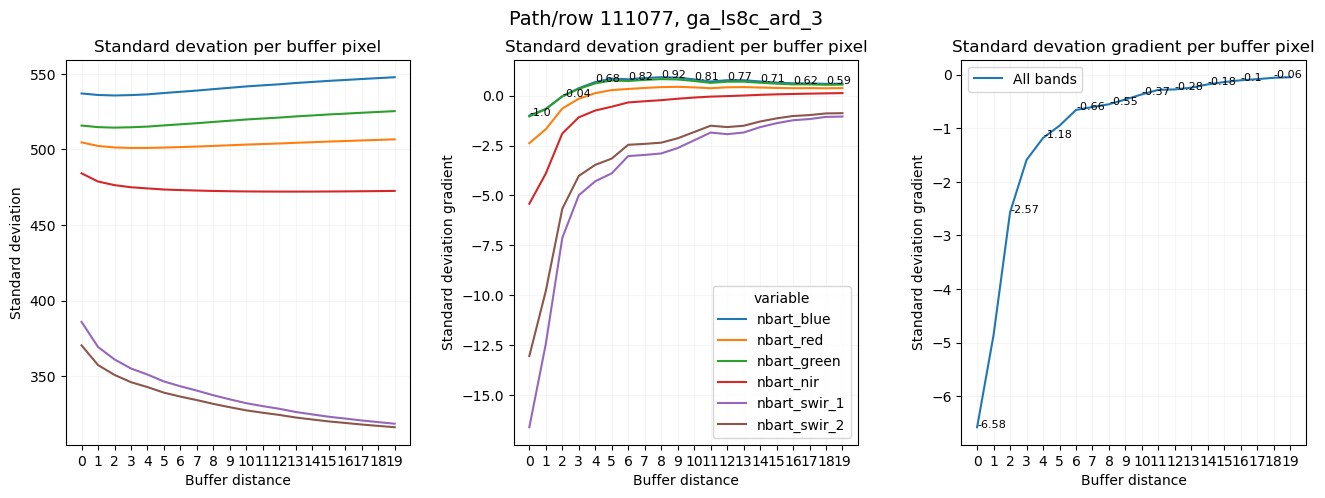

Processing path/row 111077, product ga_ls9c_ard_3
Error - possibly no data for ga_ls9c_ard_3. 'Dataset' object has no attribute 'oa_fmask'


In [10]:
# Create output folder. If it doesn't exist, create it
output_dir = f"output_data/"
os.makedirs(output_dir, exist_ok=True)

for path_row in path_row_list:
    for product in products:
        print(f"Processing path/row {path_row}, product {product}")

        # Load path rows, optionally using only a radius around the
        # path-row centroid to reduce processing time and memory use
        query_params = define_query_params(
            path_row, time_period, maturity, radius=50000
        )

        # Small test area
        # query_params = define_query_params_lat_lon_test(time_period)

        # Load data using Dask's .persist() to let us to re-use it each run
        # rather than having to reload for each buffer size
        ds = load_data(bands, product, query_params).persist()

        try:
            # Calculate cloud shadow mask
            cloud_shadow_mask, nodata_mask = calc_cloud_shadow_mask(ds)

            # Calculate standard deviation per buffer in pixels
            std_buffer_df = std_buffer_comp(
                start_buffering, end_buffering, ds, cloud_shadow_mask, nodata_mask
            )

            # Export result as csv with a "product" and "path_row" column
            std_buffer_df.assign(product=product, path_row=path_row).to_csv(
                f"output_data/{path_row}_{product}_std_buffer.csv", index=True
            )

            # Plot the standard deviation and gradient results
            plot_std_gradient_buffer(
                std_buffer_df,
                path_row,
                product,
                start_buffering,
                end_buffering,
                export_figure=True,
            )

        except Exception as e:
            print(f"Error - possibly no data for {product}. {e}")

### Experimental: plotting all tile and product outputs

In [11]:
import glob
import seaborn as sns

# Identify output CSVs
csvs = glob.glob("output_data/*csv")

# Combine into a singe dataframe
df = pd.concat((pd.read_csv(f) for f in csvs), ignore_index=True)

# Melt into long format for input into seaborn plotting
df_long = df.melt(id_vars=["product", "path_row", "pixel_buffer"], value_name="std")

# Add standard deviation gradient to dataframe
df_long["std_gradient"] = df_long.groupby(["product", "path_row", "variable"])[
    "std"
].transform(np.gradient)

# Take mean of all bands
df_long = df_long.groupby(["product", "path_row", "pixel_buffer"]).mean(
    numeric_only=True
)

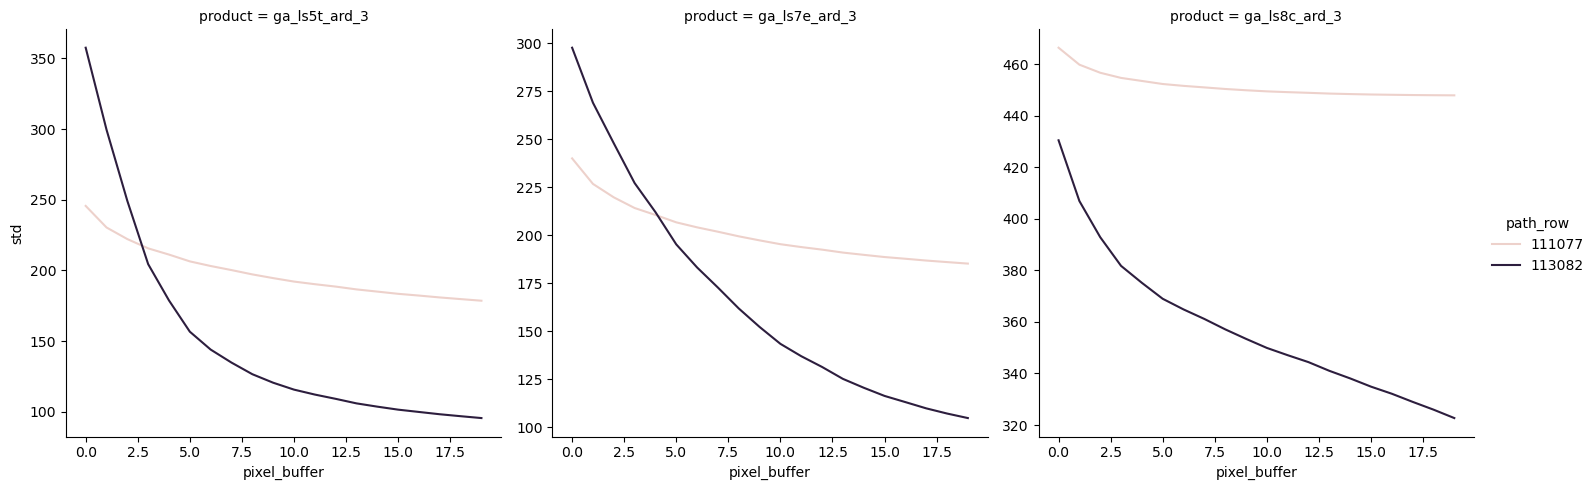

In [15]:
# Plot standard deviation across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std",
    col="product",
    hue="path_row",
    kind="line",
    facet_kws=dict(sharey=False),
)

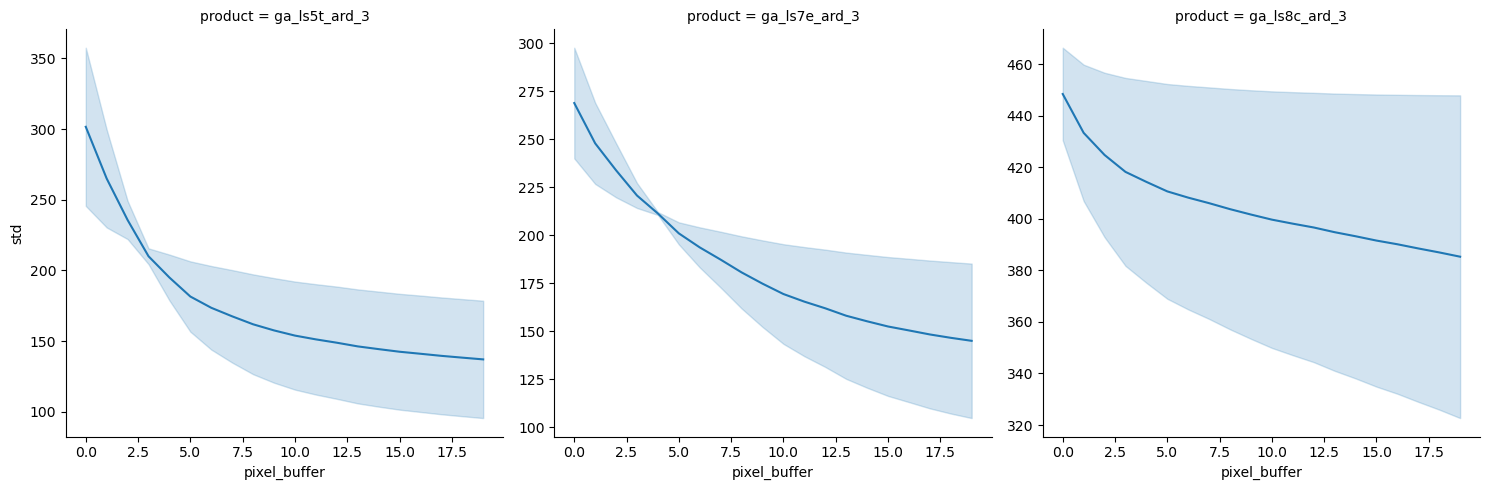

In [12]:
# Plot standard deviation across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std",
    col="product",
    kind="line",
    facet_kws=dict(sharey=False),
)

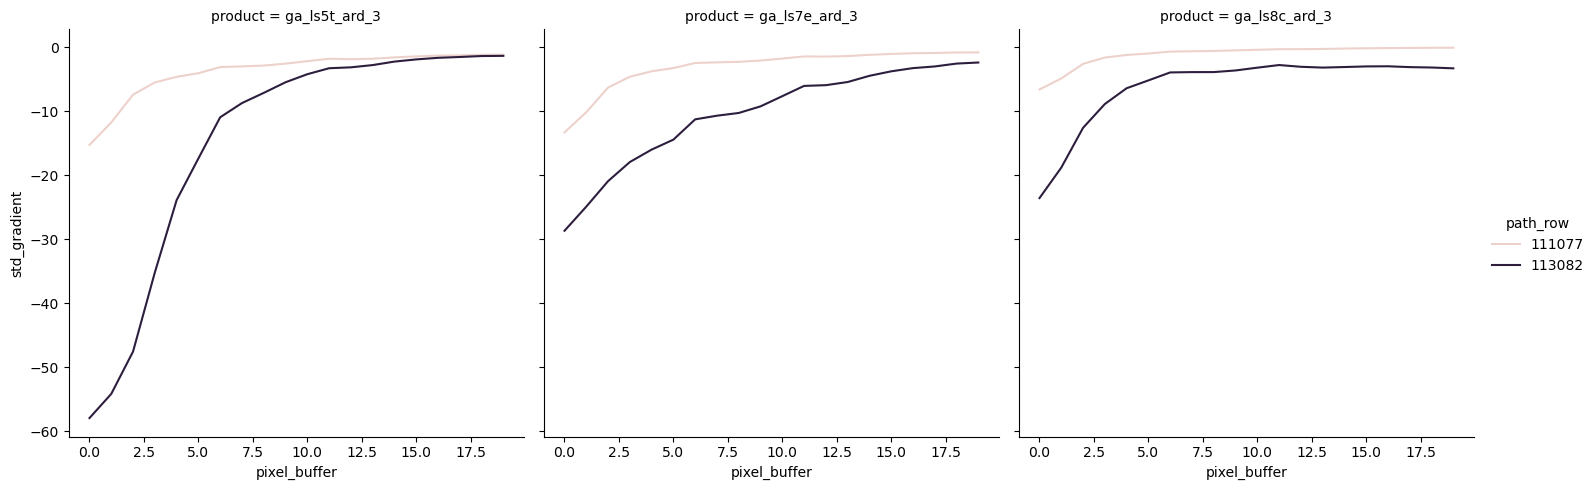

In [16]:
# Plot standard deviation gradient across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std_gradient",
    hue="path_row",
    col="product",
    kind="line",
)

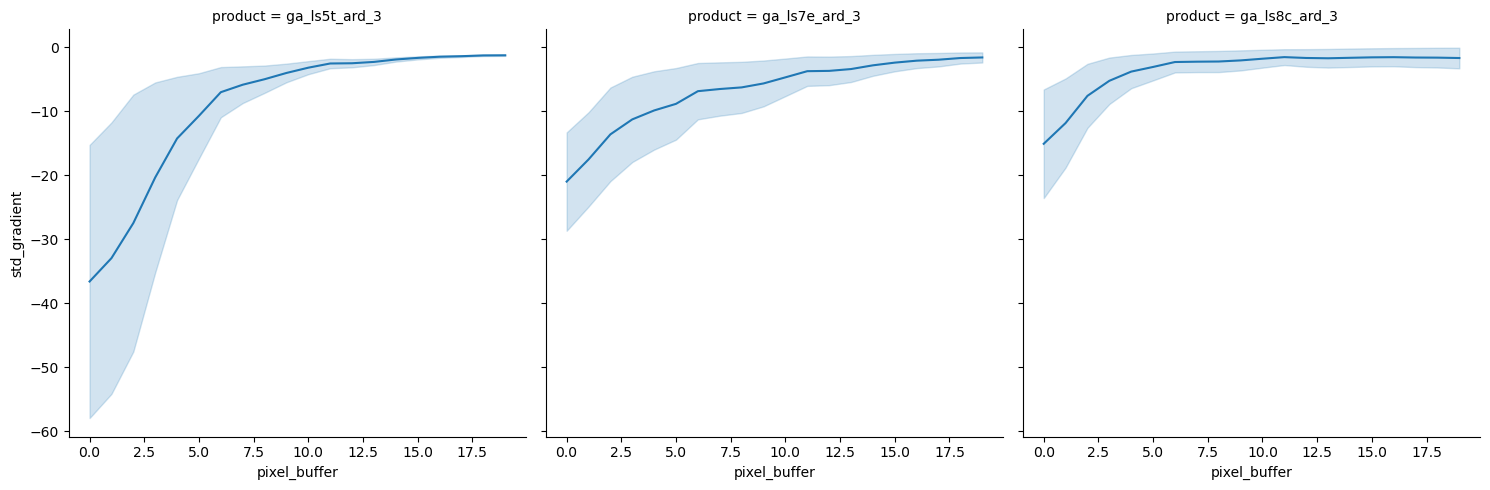

In [13]:
# Plot standard deviation gradient across all path rows and products
sns.relplot(
    data=df_long,
    x="pixel_buffer",
    y="std_gradient",
    col="product",
    kind="line",
)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2023

**Compatible datacube version:** 

In [14]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)